<a href="https://colab.research.google.com/github/juyeon-shin/CLUB-D.N.A./blob/main/%EC%9B%90%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%99%B8%EB%B6%80%EB%8D%B0%EC%9D%B4%ED%84%B0_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 원본 데이터 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc
plt.rc('font', family='NanumBarunGothic') 

import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import plotly
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb

In [4]:
data_path = '/content/drive/MyDrive/깍두기와 겉절이들/가스공급량 수요 예측/데이터/'

In [5]:
total = pd.read_csv(data_path + '한국가스공사_시간별 공급량_20181231.csv',encoding='cp949')
total

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105
...,...,...,...,...
368083,2018-12-31,20,H,681.033
368084,2018-12-31,21,H,669.961
368085,2018-12-31,22,H,657.941
368086,2018-12-31,23,H,610.953


## 1. 전처리 (데이콘 베이스 라인 기반)

In [6]:
total['구분'].unique()

array(['A', 'B', 'C', 'D', 'E', 'G', 'H'], dtype=object)

In [7]:
d_map = {}
for i, d in enumerate(total['구분'].unique()):
    d_map[d] = i
total['구분'] = total['구분'].map(d_map)

In [8]:
total['연월일'] = pd.to_datetime(total['연월일'])

In [9]:
total['year'] = total['연월일'].dt.year
total['month'] = total['연월일'].dt.month
total['day'] = total['연월일'].dt.day
total['weekday'] = total['연월일'].dt.weekday

In [10]:
train_years = [2013,2014,2015,2016,2017]
val_years = [2018]

In [11]:
train = total[total['year'].isin(train_years)]
val = total[total['year'].isin(val_years)]

In [12]:
features = ['구분', 'month', 'day', 'weekday', '시간']
train_x = train[features]
train_y = train['공급량']

val_x = val[features]
val_y = val['공급량']

In [13]:
train

,연월일,시간,구분,공급량,year,month,day,weekday
0,2013-01-01,1,0,2497.129,2013,1,1,1
1,2013-01-01,2,0,2363.265,2013,1,1,1
2,2013-01-01,3,0,2258.505,2013,1,1,1
3,2013-01-01,4,0,2243.969,2013,1,1,1
4,2013-01-01,5,0,2344.105,2013,1,1,1
...,...,...,...,...,...,...,...,...
306763,2017-12-31,20,6,517.264,2017,12,31,6
306764,2017-12-31,21,6,530.896,2017,12,31,6
306765,2017-12-31,22,6,506.287,2017,12,31,6
306766,2017-12-31,23,6,470.638,2017,12,31,6


In [14]:
val

,연월일,시간,구분,공급량,year,month,day,weekday
306768,2018-01-01,1,0,1765.008,2018,1,1,0
306769,2018-01-01,2,0,1679.186,2018,1,1,0
306770,2018-01-01,3,0,1610.885,2018,1,1,0
306771,2018-01-01,4,0,1604.123,2018,1,1,0
306772,2018-01-01,5,0,1711.506,2018,1,1,0
...,...,...,...,...,...,...,...,...
368083,2018-12-31,20,6,681.033,2018,12,31,0
368084,2018-12-31,21,6,669.961,2018,12,31,0
368085,2018-12-31,22,6,657.941,2018,12,31,0
368086,2018-12-31,23,6,610.953,2018,12,31,0


## 2. 외부데이터 전처리

In [15]:
gas_importPrice = pd.read_csv(data_path + '천연가스 수입금액지수.csv', names=['날짜', '수입금액지수'], encoding='cp949')
gas_importPrice['날짜']= pd.to_datetime(gas_importPrice['날짜'], format='%b-%y', errors='raise')
gas_importPrice['날짜'] = gas_importPrice['날짜'].astype('str')
gas_importPrice['날짜'] = gas_importPrice['날짜'].str[:-3]

gas_importPrice['수입금액지수'] = gas_importPrice['수입금액지수'].astype('float')
gas_importPrice = gas_importPrice.reset_index(drop=True)
gas_importPrice

,날짜,수입금액지수
0,2012-12,207.67
1,2013-01,193.49
2,2013-02,204.18
3,2013-03,210.42
4,2013-04,166.03
...,...,...
68,2018-08,98.49
69,2018-09,119.15
70,2018-10,139.88
71,2018-11,145.58


In [16]:
gas_consumption = pd.read_csv(data_path + '천연가스 에너지소비량.csv', names=['날짜', '소비량'], encoding='cp949')
gas_consumption['날짜'] = pd.to_datetime(gas_consumption['날짜'], format='%b-%y')
gas_consumption['날짜'] = gas_consumption['날짜'].astype('str')
gas_consumption['날짜'] = gas_consumption['날짜'].str[:-3]
gas_consumption['소비량'] = gas_consumption['소비량'].str[0] + gas_consumption['소비량'].str[2:]
gas_consumption['소비량'] = gas_consumption['소비량'].astype('int')

gas_consumption.columns = ['날짜','가스소비량']
gas_consumption

,날짜,가스소비량
0,2012-12,6485
1,2013-01,6487
2,2013-02,5291
3,2013-03,4781
4,2013-04,4348
...,...,...
68,2018-08,3754
69,2018-09,2984
70,2018-10,4022
71,2018-11,4772


In [17]:
dollar_exchangeRate = pd.read_csv(data_path + '달러환율.csv', names=['연월일', '달러환율'], encoding='cp949')
dollar_exchangeRate.columns = ['날짜','환율']
dollar_exchangeRate.columns = dollar_exchangeRate.columns
dollar_exchangeRate = dollar_exchangeRate.fillna(method='ffill')
dollar_exchangeRate['환율'] = dollar_exchangeRate['환율'].str[0] + dollar_exchangeRate['환율'].str[2:] 
dollar_exchangeRate['환율'] = dollar_exchangeRate['환율'].astype('float')
dollar_exchangeRate

,날짜,환율
0,2012-12-01,NaN
1,2012-12-02,NaN
2,2012-12-03,1082.7
3,2012-12-04,1083.5
4,2012-12-05,1083.0
...,...,...
2217,2018-12-27,1123.0
2218,2018-12-28,1120.0
2219,2018-12-29,1120.0
2220,2018-12-30,1120.0


In [18]:
mer = pd.merge(gas_importPrice,gas_consumption,on='날짜')
mer

,날짜,수입금액지수,가스소비량
0,2012-12,207.67,6485
1,2013-01,193.49,6487
2,2013-02,204.18,5291
3,2013-03,210.42,4781
4,2013-04,166.03,4348
...,...,...,...
68,2018-08,98.49,3754
69,2018-09,119.15,2984
70,2018-10,139.88,4022
71,2018-11,145.58,4772


In [19]:
temperatures = pd.read_csv(data_path + '전국일별기온.csv', encoding='cp949')
temperatures = temperatures.drop(['지점'],axis=1)
temperatures

,날짜,평균기온(℃),최저기온(℃),최고기온(℃)
0,2012-12-01,1.0,-3.5,5.7
1,2012-12-02,3.1,-0.7,8.4
2,2012-12-03,3.2,-1.3,8.4
3,2012-12-04,0.2,-2.7,3.7
4,2012-12-05,0.0,-3.8,5.4
...,...,...,...,...
2217,2018-12-27,-4.8,-8.1,-0.5
2218,2018-12-28,-7.0,-10.7,-2.7
2219,2018-12-29,-5.1,-9.5,-0.7
2220,2018-12-30,-4.7,-9.4,0.9


## train 원데이터 + 외부데이터

In [20]:
train['연월일'] = train['연월일'].astype('str')
train['연월'] = train['연월일'].str[:-3]
train

,연월일,시간,구분,공급량,year,month,day,weekday,연월
0,2013-01-01,1,0,2497.129,2013,1,1,1,2013-01
1,2013-01-01,2,0,2363.265,2013,1,1,1,2013-01
2,2013-01-01,3,0,2258.505,2013,1,1,1,2013-01
3,2013-01-01,4,0,2243.969,2013,1,1,1,2013-01
4,2013-01-01,5,0,2344.105,2013,1,1,1,2013-01
...,...,...,...,...,...,...,...,...,...
306763,2017-12-31,20,6,517.264,2017,12,31,6,2017-12
306764,2017-12-31,21,6,530.896,2017,12,31,6,2017-12
306765,2017-12-31,22,6,506.287,2017,12,31,6,2017-12
306766,2017-12-31,23,6,470.638,2017,12,31,6,2017-12


In [21]:
train_mer = pd.merge(train,mer,left_on='연월',right_on='날짜')
train_mer = pd.merge(train_mer,temperatures,left_on='연월일',right_on='날짜')
train_mer = pd.merge(train_mer,dollar_exchangeRate,left_on='연월일',right_on='날짜')
train_mer = train_mer.drop(['연월','날짜_x','날짜_y','날짜'],axis=1)
train_mer

,연월일,시간,구분,공급량,year,month,day,weekday,수입금액지수,가스소비량,평균기온(℃),최저기온(℃),최고기온(℃),환율
0,2013-01-01,1,0,2497.129,2013,1,1,1,193.49,6487,-3.2,-9.1,2.6,1071.3
1,2013-01-01,2,0,2363.265,2013,1,1,1,193.49,6487,-3.2,-9.1,2.6,1071.3
2,2013-01-01,3,0,2258.505,2013,1,1,1,193.49,6487,-3.2,-9.1,2.6,1071.3
3,2013-01-01,4,0,2243.969,2013,1,1,1,193.49,6487,-3.2,-9.1,2.6,1071.3
4,2013-01-01,5,0,2344.105,2013,1,1,1,193.49,6487,-3.2,-9.1,2.6,1071.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306763,2017-12-31,20,6,517.264,2017,12,31,6,114.29,6569,2.1,-2.0,5.8,1076.0
306764,2017-12-31,21,6,530.896,2017,12,31,6,114.29,6569,2.1,-2.0,5.8,1076.0
306765,2017-12-31,22,6,506.287,2017,12,31,6,114.29,6569,2.1,-2.0,5.8,1076.0
306766,2017-12-31,23,6,470.638,2017,12,31,6,114.29,6569,2.1,-2.0,5.8,1076.0


In [22]:
col_list = train_mer.columns.tolist()
col_list.remove('공급량')
col_list.append('공급량')

train_mer = train_mer[col_list]
train_mer

,연월일,시간,구분,year,month,day,weekday,수입금액지수,가스소비량,평균기온(℃),최저기온(℃),최고기온(℃),환율,공급량
0,2013-01-01,1,0,2013,1,1,1,193.49,6487,-3.2,-9.1,2.6,1071.3,2497.129
1,2013-01-01,2,0,2013,1,1,1,193.49,6487,-3.2,-9.1,2.6,1071.3,2363.265
2,2013-01-01,3,0,2013,1,1,1,193.49,6487,-3.2,-9.1,2.6,1071.3,2258.505
3,2013-01-01,4,0,2013,1,1,1,193.49,6487,-3.2,-9.1,2.6,1071.3,2243.969
4,2013-01-01,5,0,2013,1,1,1,193.49,6487,-3.2,-9.1,2.6,1071.3,2344.105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306763,2017-12-31,20,6,2017,12,31,6,114.29,6569,2.1,-2.0,5.8,1076.0,517.264
306764,2017-12-31,21,6,2017,12,31,6,114.29,6569,2.1,-2.0,5.8,1076.0,530.896
306765,2017-12-31,22,6,2017,12,31,6,114.29,6569,2.1,-2.0,5.8,1076.0,506.287
306766,2017-12-31,23,6,2017,12,31,6,114.29,6569,2.1,-2.0,5.8,1076.0,470.638


In [23]:
train_mer.to_csv(data_path +'train_mer.csv',index=False)

## val 원데이터 + 외부 데이터

In [24]:
val['연월일'] = val['연월일'].astype('str')
val['연월'] = val['연월일'].str[:-3]
val

,연월일,시간,구분,공급량,year,month,day,weekday,연월
306768,2018-01-01,1,0,1765.008,2018,1,1,0,2018-01
306769,2018-01-01,2,0,1679.186,2018,1,1,0,2018-01
306770,2018-01-01,3,0,1610.885,2018,1,1,0,2018-01
306771,2018-01-01,4,0,1604.123,2018,1,1,0,2018-01
306772,2018-01-01,5,0,1711.506,2018,1,1,0,2018-01
...,...,...,...,...,...,...,...,...,...
368083,2018-12-31,20,6,681.033,2018,12,31,0,2018-12
368084,2018-12-31,21,6,669.961,2018,12,31,0,2018-12
368085,2018-12-31,22,6,657.941,2018,12,31,0,2018-12
368086,2018-12-31,23,6,610.953,2018,12,31,0,2018-12


In [25]:
val_mer = pd.merge(val,mer,left_on='연월',right_on='날짜')
val_mer = pd.merge(val_mer,temperatures,left_on='연월일',right_on='날짜')
val_mer = pd.merge(val_mer,dollar_exchangeRate,left_on='연월일',right_on='날짜')
val_mer = val_mer.drop(['연월','날짜_x','날짜_y','날짜'],axis=1)

val_mer

,연월일,시간,구분,공급량,year,month,day,weekday,수입금액지수,가스소비량,평균기온(℃),최저기온(℃),최고기온(℃),환율
0,2018-01-01,1,0,1765.008,2018,1,1,0,119.47,7013,-0.4,-4.9,5.2,1076.0
1,2018-01-01,2,0,1679.186,2018,1,1,0,119.47,7013,-0.4,-4.9,5.2,1076.0
2,2018-01-01,3,0,1610.885,2018,1,1,0,119.47,7013,-0.4,-4.9,5.2,1076.0
3,2018-01-01,4,0,1604.123,2018,1,1,0,119.47,7013,-0.4,-4.9,5.2,1076.0
4,2018-01-01,5,0,1711.506,2018,1,1,0,119.47,7013,-0.4,-4.9,5.2,1076.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61315,2018-12-31,20,6,681.033,2018,12,31,0,172.60,6381,-3.2,-9.9,4.0,1120.0
61316,2018-12-31,21,6,669.961,2018,12,31,0,172.60,6381,-3.2,-9.9,4.0,1120.0
61317,2018-12-31,22,6,657.941,2018,12,31,0,172.60,6381,-3.2,-9.9,4.0,1120.0
61318,2018-12-31,23,6,610.953,2018,12,31,0,172.60,6381,-3.2,-9.9,4.0,1120.0


In [26]:
col_list = val_mer.columns.tolist()
col_list.remove('공급량')
col_list.append('공급량')

val_mer = val_mer[col_list]
val_mer

,연월일,시간,구분,year,month,day,weekday,수입금액지수,가스소비량,평균기온(℃),최저기온(℃),최고기온(℃),환율,공급량
0,2018-01-01,1,0,2018,1,1,0,119.47,7013,-0.4,-4.9,5.2,1076.0,1765.008
1,2018-01-01,2,0,2018,1,1,0,119.47,7013,-0.4,-4.9,5.2,1076.0,1679.186
2,2018-01-01,3,0,2018,1,1,0,119.47,7013,-0.4,-4.9,5.2,1076.0,1610.885
3,2018-01-01,4,0,2018,1,1,0,119.47,7013,-0.4,-4.9,5.2,1076.0,1604.123
4,2018-01-01,5,0,2018,1,1,0,119.47,7013,-0.4,-4.9,5.2,1076.0,1711.506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61315,2018-12-31,20,6,2018,12,31,0,172.60,6381,-3.2,-9.9,4.0,1120.0,681.033
61316,2018-12-31,21,6,2018,12,31,0,172.60,6381,-3.2,-9.9,4.0,1120.0,669.961
61317,2018-12-31,22,6,2018,12,31,0,172.60,6381,-3.2,-9.9,4.0,1120.0,657.941
61318,2018-12-31,23,6,2018,12,31,0,172.60,6381,-3.2,-9.9,4.0,1120.0,610.953


In [27]:
val_mer.to_csv(data_path+'val_mer.csv',index=False)

## 3. 외부데이터 EDA

In [28]:
def EDA(a):
  data = a
  data['날짜'] = pd.to_datetime(data['날짜'])
  for i in range(len(data.columns)):
    plt.plot(data['날짜'],data[data.columns[i]])
    plt.title('%s 그래프' %data.columns[i])
    plt.show()

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


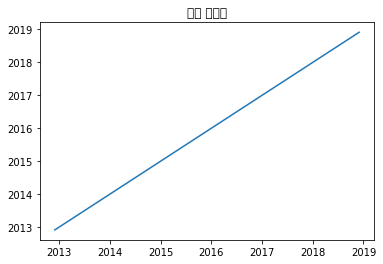

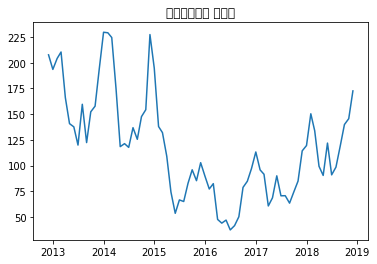

In [30]:
EDA(gas_importPrice)

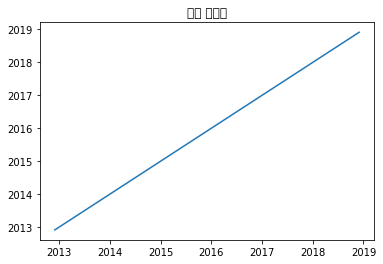

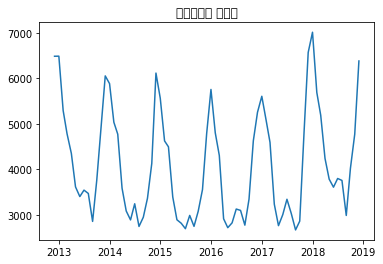

In [31]:
EDA(gas_consumption)

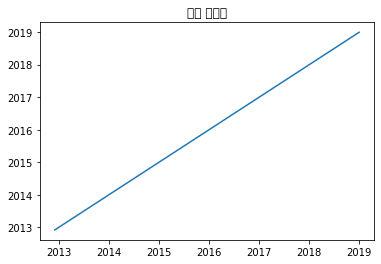

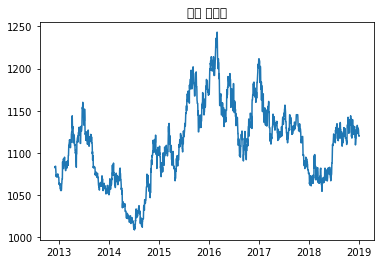

In [32]:
EDA(dollar_exchangeRate)

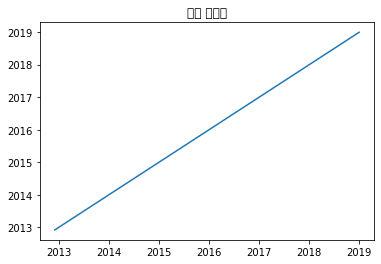

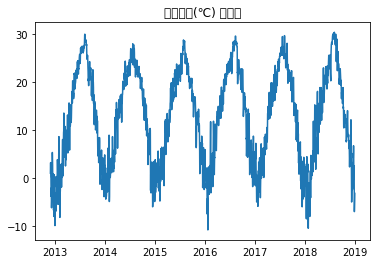

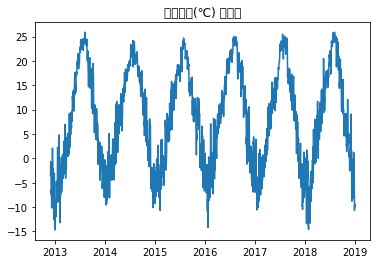

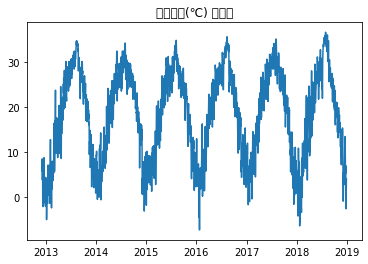

In [33]:
EDA(temperatures)